In [25]:
import pandas as pd

#Loading CSV into data Frame
df=pd.read_csv('/content/sample_data/Bank_Personal_Loan_Modelling.csv')
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [29]:
#lets get some basic info and check for missing values

df.info()

df.isnull().sum()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


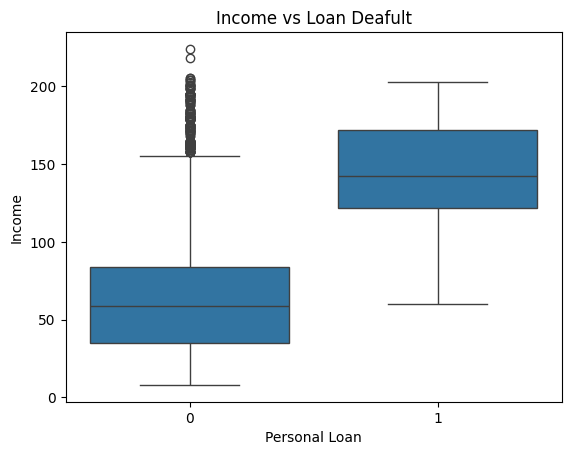

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

#Plot default vs income

sns.boxplot(x='Personal Loan',y='Income',data=df)
plt.title('Income vs Loan Deafult')
plt.show()

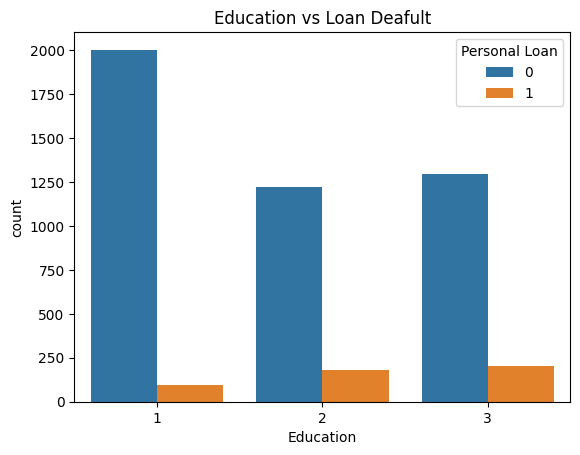

In [31]:
#Lets us visulize the Education vs Personal Loan
sns.countplot(x='Education', hue='Personal Loan',data=df)
plt.title('Education vs Loan Deafult')
plt.show()

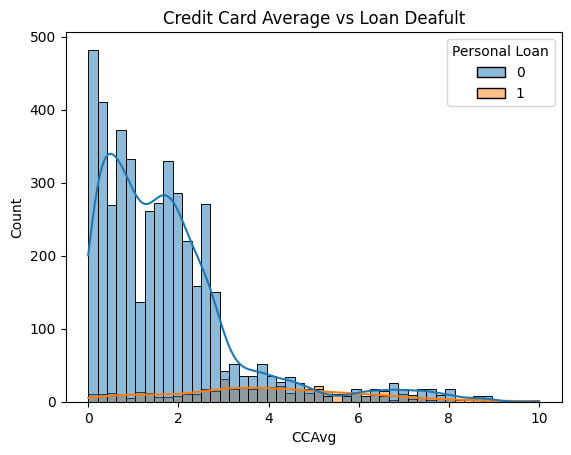

In [35]:
sns.histplot(data=df, x='CCAvg', hue='Personal Loan', kde=True)
plt.title('Credit Card Average vs Loan Deafult')
plt.show()

In [34]:
#Dropping Irrelevant Columns

df=df.drop(columns=['ID','ZIP Code'])

In [36]:
#We will cluster groups based on the spending and earning behaviours

cluster_features = df[['Income', 'CCAvg', 'Mortgage', 'Family', 'Experience']]

#Scaling the features (because clustering depends on distances)


from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_features=scaler.fit_transform(cluster_features)


In [37]:
# We will use Kmeans Clustering

from sklearn.cluster import KMeans

#Try 3 different Behaviour Groups
kmeans=KMeans(n_clusters=3,random_state=42)
df['Behaviour_Group']=kmeans.fit_predict(scaled_features)

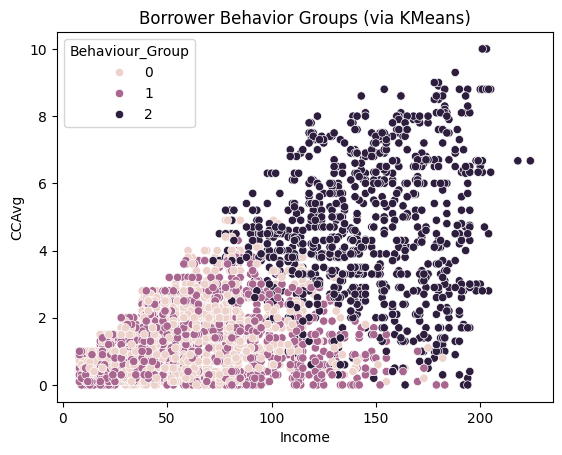

In [38]:
# Visualise the clusters

sns.scatterplot(x='Income',y='CCAvg',hue='Behaviour_Group',data=df)
plt.title("Borrower Behavior Groups (via KMeans)")
plt.show()



In [44]:
#Prepare the data

from sklearn.model_selection import train_test_split

X=df.drop(columns=['Personal Loan'])
y=df['Personal Loan']

# Convert categorical feature (Behaviour_Group) to one-hot to avoid ordinal inference issues in the model
X = pd.get_dummies(X, columns=['Behaviour_Group'], drop_first=True)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [46]:
# Train the random forest model

from sklearn.ensemble import RandomForestClassifier

rf_model=RandomForestClassifier(random_state=42)
rf_model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [48]:
#Train an XGBoost model

from  xgboost import XGBClassifier

xgb_model=XGBClassifier(use_label_encoder=False,eval_metric='logloss')
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [49]:
#Evaluating both models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

# Evaluation
print("Random Forest Performance:")
print(confusion_matrix(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

print("XGBoost Performance:")
print(confusion_matrix(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))


Random Forest Performance:
[[894   1]
 [  9  96]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       895
           1       0.99      0.91      0.95       105

    accuracy                           0.99      1000
   macro avg       0.99      0.96      0.97      1000
weighted avg       0.99      0.99      0.99      1000

XGBoost Performance:
[[892   3]
 [  5 100]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       895
           1       0.97      0.95      0.96       105

    accuracy                           0.99      1000
   macro avg       0.98      0.97      0.98      1000
weighted avg       0.99      0.99      0.99      1000



In [50]:
#Optimising models using Grid Search CV

from sklearn.model_selection import GridSearchCV

#Defining hyperparamter grids for Random Forests
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

#Defining hyperparameter grid for XGBOOST

xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

In [52]:
#Using grid search cv

#Random Forests
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       rf_params,
                       cv=3,
                       scoring='f1',
                       n_jobs=-1)
rf_grid.fit(X_train, y_train)

#XGBoost

xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                        xgb_params,
                        cv=3,
                        scoring='f1',
                        n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print("Best RF Params:", rf_grid.best_params_)
print("Best RF F1 Score:", rf_grid.best_score_)

print("Best XGB Params:", xgb_grid.best_params_)
print("Best XGB F1 Score:", xgb_grid.best_score_)



Best RF Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RF F1 Score: 0.9096111327870985
Best XGB Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best XGB F1 Score: 0.9176979643081338


In [56]:
#Evaluating the optimised models on test data

rf_best = rf_grid.best_estimator_
xgb_best = xgb_grid.best_estimator_

# Predictions
rf_tuned_preds = rf_best.predict(X_test)
xgb_tuned_preds = xgb_best.predict(X_test)

# Calculating AUC
rf_tuned_proba = rf_best.predict_proba(X_test)[:, 1]
xgb_tuned_proba = xgb_best.predict_proba(X_test)[:, 1]



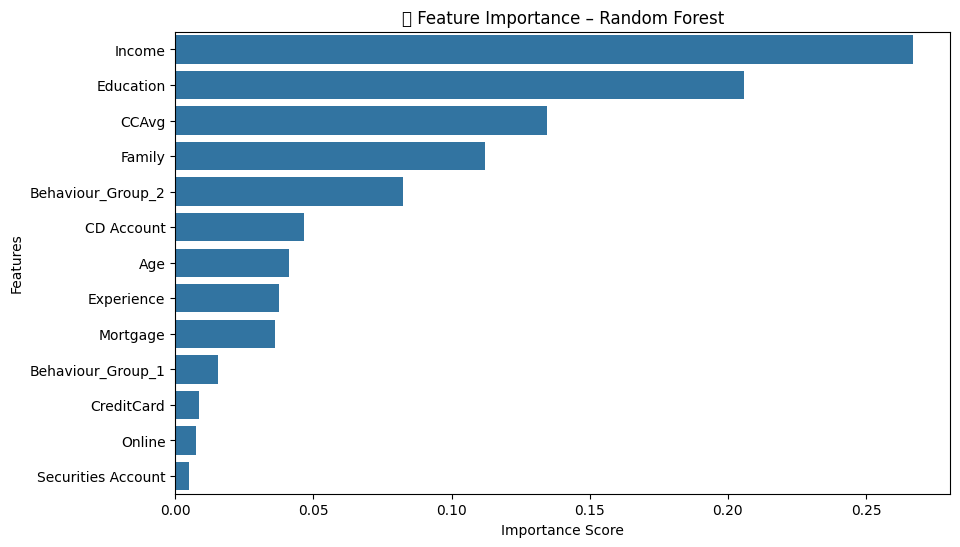

In [57]:
#Identyfing the Feature Importance for Random Forest

import numpy as np

# Get feature importances
importances = rf_best.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Feature Importance – Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

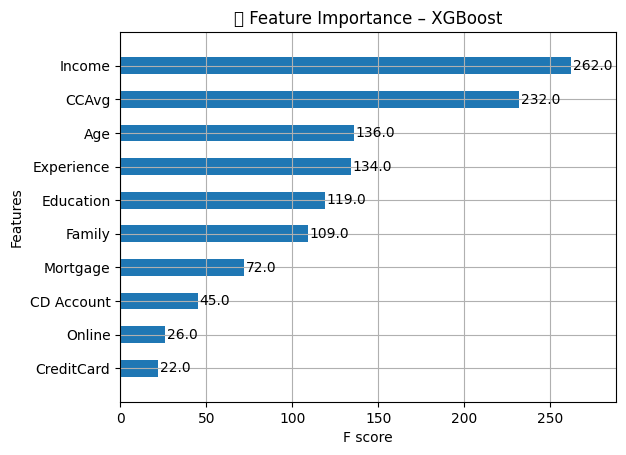

In [61]:
#Feature Importance for XGBoost
import xgboost as xgb
xgb.plot_importance(xgb_best, max_num_features=10, height=0.5)
plt.title("🔍 Feature Importance – XGBoost")
plt.show()

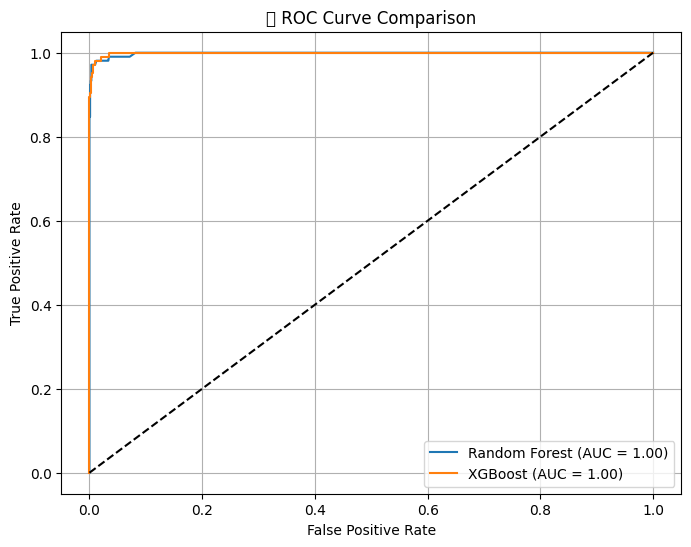

In [62]:
#Plotting the ROC Curve

from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_tuned_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_tuned_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(auc(fpr_rf, tpr_rf)))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(auc(fpr_xgb, tpr_xgb)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()


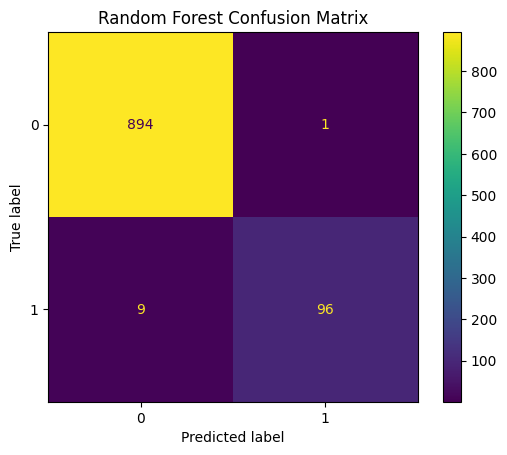

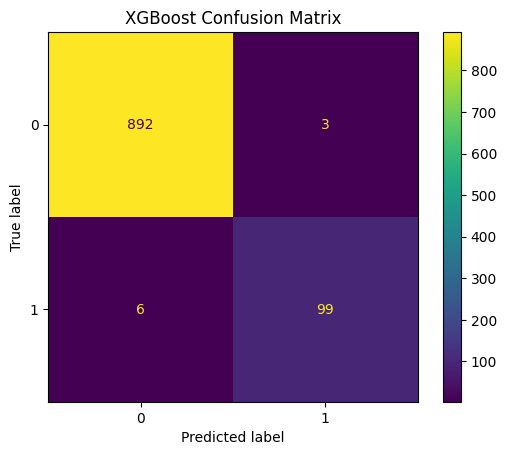

In [63]:
#Confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(rf_best, X_test, y_test)
plt.title("Random Forest Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(xgb_best, X_test, y_test)
plt.title("XGBoost Confusion Matrix")
plt.show()


In [64]:
#Classification reports for Random Forest and XGB
from sklearn.metrics import classification_report

print("Classification Report – XGBoost (Optimised)")
print(classification_report(y_test, xgb_tuned_preds, digits=3))

print("Classification Report – Random Forest (Optimised)")
print(classification_report(y_test, rf_tuned_preds, digits=3))




Classification Report – XGBoost (Optimised)
              precision    recall  f1-score   support

           0      0.993     0.997     0.995       895
           1      0.971     0.943     0.957       105

    accuracy                          0.991      1000
   macro avg      0.982     0.970     0.976      1000
weighted avg      0.991     0.991     0.991      1000

Classification Report – Random Forest (Optimised)
              precision    recall  f1-score   support

           0      0.990     0.999     0.994       895
           1      0.990     0.914     0.950       105

    accuracy                          0.990      1000
   macro avg      0.990     0.957     0.972      1000
weighted avg      0.990     0.990     0.990      1000

